<a href="https://colab.research.google.com/github/ManelSoengas/NLP_Curs/blob/main/Utilitzant_Transformers_Unigram_Tokenizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tokenització Unigram**

---



És un mètode basat en un model probabilístic de subparaules (subwords) que aprèn un vocabulari i segmenta el text en unitats que maximitzen la versemblança.

**Com funciona?**

Inicialització del vocabulari

1. Es parteix d’un gran conjunt de fragments possibles (caràcters, síl·labes, subparaules extra).

1. Estimació de probabilitats
  * Cada fragment té assignada una probabilitat inicial.

1. Optimització iterativa
  * S’analitzen exemples de text i, per a cada paraula, es calculen totes les possibles segmentacions en fragments.
  * Es selecciona la segmentació que maximitza la probabilitat conjunta (producte de les probabilitats dels fragments).
  * Per reduir la mida del vocabulari, s’elimina iterativament el fragment menys «útil» (el que menys contribueix a la probabilitat global), recalculant després les probabilitats.
  * Es repeteix fins aconseguir la mida de vocabulari desitjada.

**Per què serveix?**

Model obert (open vocabulary):
1. Permet tractar paraules desconegudes segmentant-les en fragments coneguts, evitant tokens ‹UNK› massius.

1. Vocabulari compacte i eficient:
Amb un nombre moderat de subparaules captures tant formes comunes com variacions morfològiques.

1. Probabilístic i flexible:
A diferència de mètodes que sempre trien la fragmentació més llarga (greedy), Unigram busca la millor combinació global segons un model estadístic.

1. Adaptabilitat a l’idioma i domini:
El vocabulari s’ajusta automàticament al corpus d’entrenament, capturant patrons de l’idioma o vocabulari específic (mèdic, legal, tècnic…).



Unigram funciona en l'altra direcció: parteix d'un gran vocabulari i n'elimina fitxes fins que assoleix la mida de vocabulari desitjada. Hi ha diverses opcions a utilitzar per construir aquest vocabulari base: podem agafar les subcadenes més habituals en paraules prèviament tokenitzades

Reutilitzarem el corpus dels exemples anteriors:

```
("hug", 10), ("pug", 5), ("pun", 12), ("bun", 4), ("hugs", 5)
```
i per a aquest exemple, agafarem totes les subcadenes estrictes per al vocabulari inicial:


```
["h", "u", "g", "hu", "ug", "p", "pu", "n", "un", "b", "bu", "s", "hug", "gs", "ugs"]
```
Aquí teniu les freqüències de totes les subparaules possibles del vocabulari


```
("h", 15) ("u", 36) ("g", 20) ("hu", 15) ("ug", 20) ("p", 17) ("pu", 17) ("n", 16)
("un", 16) ("b", 4) ("bu", 4) ("s", 5) ("hug", 15) ("gs", 5) ("ugs", 5)
```






Ara, per tokenitzar una paraula donada, observem totes les segmentacions possibles en fitxes i calculem la probabilitat de cadascuna segons el model Unigram. Com que totes les fitxes es consideren independents, aquesta probabilitat és només el producte de la probabilitat de cada fitxa. Per exemple, la tokenització ["p", "u", "g"] de "pug" té la probabilitat:

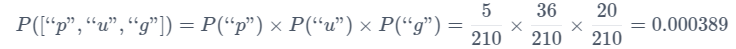

Comparativament, la tokenització ["pu", "g"] té la probabilitat:

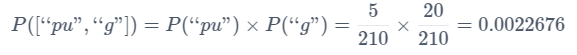

de manera que un és molt més probable. En general, les fitxes amb menys fitxes possibles tindran la probabilitat més alta (a causa d'aquesta divisió per 210 repetida per a cada testimoni), que correspon al que volem intuïtivament: dividir una paraula en el menor nombre de fitxes possibles.

La tokenització d'una paraula amb el model Unigram és llavors la tokenització amb més probabilitat. En l'exemple de "pug", aquí teniu les probabilitats que obtindríem per a cada possible segmentació:



```
["p", "u", "g"] : 0.000389
["p", "ug"] : 0.0022676
["pu", "g"] : 0.0022676
```



Per tant, "pug" es representaria com a ["p", "ug"] o ["pu", "g"], depenent de quina d'aquestes segmentacions es trobi primer (tingueu en compte que en un corpus més gran, casos d'igualtat com aquest seran rars).

En aquest cas, va ser fàcil trobar totes les segmentacions possibles i calcular-ne les probabilitats, però en general serà una mica més difícil. Hi ha un algorisme clàssic utilitzat per a això, anomenat algorisme de Viterbi. Essencialment, podem construir un gràfic per detectar les possibles segmentacions d'una paraula donada dient que hi ha una branca del caràcter a al caràcter b si la subparaula de a a b està al vocabulari, i atribuir a aquesta branca la probabilitat de la subparaula.

Per trobar el camí en aquest gràfic que tindrà la millor puntuació, l'algoritme de Viterbi determina, per a cada posició de la paraula, la segmentació amb la millor puntuació que acaba en aquesta posició. Com que anem del principi al final, la millor puntuació es pot trobar fent un bucle per totes les subparaules que acaben a la posició actual i després utilitzant la millor puntuació de tokenització de la posició en què comença aquesta subparaula. Aleshores, només ens queda desenrotllar el camí fet per arribar al final.

Mirem un exemple amb el nostre vocabulari i la paraula "unhug". Per a cada posició, les subparaules amb les millors puntuacions que acaben aquí són les següents:



```
Character 0 (u): "u" (score 0.171429)
Character 1 (n): "un" (score 0.076191)
Character 2 (h): "un" "h" (score 0.005442)
Character 3 (u): "un" "hu" (score 0.005442)
Character 4 (g): "un" "hug" (score 0.005442)
```
Per tant, "unhug" es representaria com a ["un", "hug"].


# **Tornada als entrenaments**

---


Ara que hem vist com funciona la tokenització, podem aprofundir una mica més en la pèrdua utilitzada durant l'entrenament. En qualsevol etapa donada, aquesta pèrdua es calcula tokenitzant cada paraula del corpus, utilitzant el vocabulari actual i el model Unigram determinat per les freqüències de cada testimoni del corpus (com s'ha vist abans).

Cada paraula del corpus té una puntuació, i la pèrdua és el logaritme de probabilitat negatiu d'aquestes puntuacions, és a dir, la suma de totes les paraules del corpus de tots els -log(P(paraula)).

Tornem al nostre exemple amb el següent corpus:

("hug", 10), ("pug", 5), ("pun", 12), ("bun", 4), ("hugs", 5)



```
"hug": ["hug"] (score 0.071428)
"pug": ["pu", "g"] (score 0.007710)
"pun": ["pu", "n"] (score 0.006168)
"bun": ["bu", "n"] (score 0.001451)
"hugs": ["hug", "s"] (score 0.001701)
```



Per tant, la pèrdua és:


```
10 * (-log(0.071428)) + 5 * (-log(0.007710)) + 12 * (-log(0.006168)) + 4 * (-log(0.001451)) + 5 * (-log(0.001701)) = 169.8
```



Ara hem de calcular com l'eliminació de cada testimoni afecta la pèrdua. Això és bastant tediós, així que només ho farem per dues fitxes aquí i guardarem tot el procés per quan tinguem codi que ens ajudi. En aquest cas (molt) particular, teníem dues tokenitzacions equivalents de totes les paraules: com hem vist abans, per exemple, "pug" es podia tokenitzar ["p", "ug"] amb la mateixa puntuació. Per tant, eliminar el testimoni "pu" del vocabulari donarà exactament la mateixa pèrdua.

D'altra banda, eliminar "hug" empitjorarà la pèrdua, perquè la tokenització de "hug" i "hugs" es convertirà en:

```
"hug": ["hu", "g"] (score 0.006802)
"hugs": ["hu", "gs"] (score 0.001701)
```

Per tant, el testimoni "pu" probablement s'eliminarà del vocabulari, però no "hug".

Aquests canvis provocaran que la pèrdua augmenti per:

```
- 10 * (-log(0.071428)) + 10 * (-log(0.006802)) = 23.5
```



# **Implementació d'Unigram**

---


Ara implementem tot el que hem vist fins ara en codi. Igual que amb BPE i WordPiece, aquesta no és una implementació eficient de l'algoritme Unigram (tot el contrari), però us hauria d'ajudar a entendre-ho una mica millor.

Utilitzarem el mateix corpus que abans com a exemple:

```
corpus = [
    "This is the Hugging Face Course.",
    "This chapter is about tokenization.",
    "This section shows several tokenizer algorithms.",
    "Hopefully, you will be able to understand how they are trained and generate tokens.",
]
```



In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")

In [5]:
corpus=[
'This is the Hugging Face Course.',
'This chapter is about tokenization.',
'This section shows several tokenizer algorithms.',
'hopefully, you will be able to understand how they are trained and generate tokens.',
]

In [ ]:
# Igual que per a BPE i WordPiece, comencem comptant el nombre d'ocurrències de cada paraula al corpus:

from collections import defaultdict

word_freqs = defaultdict(int)
for text in corpus:
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    new_words = [word for word, offset in words_with_offsets]
    for word in new_words:
        word_freqs[word] += 1

word_freqs

Aleshores, hem d'iniciar el nostre vocabulari a una cosa més gran que la mida del vocabulari que volem al final. Hem d'incloure tots els caràcters bàsics (en cas contrari no podrem tokenitzar cada paraula), però per a les subcadenes més grans només en conservarem els més habituals, així que els ordenem per freqüència:

In [ ]:
char_freqs = defaultdict(int)
subwords_freqs = defaultdict(int)
for word, freq in word_freqs.items():
    for i in range(len(word)):
        char_freqs[word[i]] += freq
        # Loop through the subwords of length at least 2
        for j in range(i + 2, len(word) + 1):
            subwords_freqs[word[i:j]] += freq

# Sort subwords by frequency
sorted_subwords = sorted(subwords_freqs.items(), key=lambda x: x[1], reverse=True)
sorted_subwords[:10]

In [8]:
token_freqs = list(char_freqs.items()) + sorted_subwords[: 300 - len(char_freqs)]
token_freqs = {token: freq for token, freq in token_freqs}

A continuació, calculem la suma de totes les freqüències, per convertir les freqüències en probabilitats. Per al nostre model emmagatzemarem els logaritmes de les probabilitats, perquè és més estable numèricament sumar logaritmes que multiplicar nombres petits, i això simplificarà el càlcul de la pèrdua del model:

In [9]:
from math import log

total_sum = sum([freq for token, freq in token_freqs.items()])
model = {token: -log(freq / total_sum) for token, freq in token_freqs.items()}

Ara la funció principal és la que tokenitza paraules mitjançant l'algorisme de Viterbi. Com hem vist abans, aquest algorisme calcula la millor segmentació de cada subcadena de la paraula, que emmagatzemarem en una variable anomenada best_segmentations. Emmagatzemarem un diccionari per posició de la paraula (de 0 a la seva longitud total), amb dues claus: l'índex de l'inici de l'últim testimoni en la millor segmentació, i la puntuació de la millor segmentació. Amb l'índex de l'inici de l'últim testimoni, podrem recuperar la segmentació completa un cop la llista estigui completament emplenada.

Omplir la llista es fa amb només dos bucles: el bucle principal passa per sobre de cada posició inicial i el segon bucle prova totes les subcadenes que comencen en aquesta posició inicial. Si la subcadena es troba al vocabulari, tenim una nova segmentació de la paraula fins a aquesta posició final, que comparem amb la que hi ha a best_segmentations.

Un cop acabat el bucle principal, només comencem des del final i saltem d'una posició inicial a la següent, enregistrant les fitxes a mesura que avancem, fins a arribar a l'inici de la paraula:

In [10]:
def encode_word(word, model):
    best_segmentations = [{"start": 0, "score": 1}] + [
        {"start": None, "score": None} for _ in range(len(word))
    ]
    for start_idx in range(len(word)):
        # This should be properly filled by the previous steps of the loop
        best_score_at_start = best_segmentations[start_idx]["score"]
        for end_idx in range(start_idx + 1, len(word) + 1):
            token = word[start_idx:end_idx]
            if token in model and best_score_at_start is not None:
                score = model[token] + best_score_at_start
                # If we have found a better segmentation ending at end_idx, we update
                if (
                    best_segmentations[end_idx]["score"] is None
                    or best_segmentations[end_idx]["score"] > score
                ):
                    best_segmentations[end_idx] = {"start": start_idx, "score": score}

    segmentation = best_segmentations[-1]
    if segmentation["score"] is None:
        # We did not find a tokenization of the word -> unknown
        return ["<unk>"], None

    score = segmentation["score"]
    start = segmentation["start"]
    end = len(word)
    tokens = []
    while start != 0:
        tokens.insert(0, word[start:end])
        next_start = best_segmentations[start]["start"]
        end = start
        start = next_start
    tokens.insert(0, word[start:end])
    return tokens, score

In [ ]:
print(encode_word("Hopefully", model))
print(encode_word("This", model))

In [12]:
def compute_loss(model):
    loss = 0
    for word, freq in word_freqs.items():
        _, word_loss = encode_word(word, model)
        loss += freq * word_loss
    return loss

In [ ]:
compute_loss(model)

In [14]:
import copy


def compute_scores(model):
    scores = {}
    model_loss = compute_loss(model)
    for token, score in model.items():
        # We always keep tokens of length 1
        if len(token) == 1:
            continue
        model_without_token = copy.deepcopy(model)
        _ = model_without_token.pop(token)
        scores[token] = compute_loss(model_without_token) - model_loss
    return scores

In [ ]:
scores = compute_scores(model)
print(scores["ll"])
print(scores["his"])

Amb tot això al seu lloc, l'últim que hem de fer és afegir les fitxes especials utilitzades pel model al vocabulari, després fer un bucle fins que tinguem prou fitxes del vocabulari per assolir la mida desitjada:

In [16]:
percent_to_remove = 0.1
while len(model) > 100:
    scores = compute_scores(model)
    sorted_scores = sorted(scores.items(), key=lambda x: x[1])
    # Remove percent_to_remove tokens with the lowest scores.
    for i in range(int(len(model) * percent_to_remove)):
        _ = token_freqs.pop(sorted_scores[i][0])

    total_sum = sum([freq for token, freq in token_freqs.items()])
    model = {token: -log(freq / total_sum) for token, freq in token_freqs.items()}

In [ ]:
def tokenize(text, model):
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)
    pre_tokenized_text = [word for word, offset in words_with_offsets]
    encoded_words = [encode_word(word, model)[0] for word in pre_tokenized_text]
    return sum(encoded_words, [])


tokenize("This is the Hugging Face course.", model)